In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import os
from google.colab import files
import zipfile
import shutil

In [2]:
print("Upload your dataset ZIP file:")
uploaded_dataset = files.upload()  # Upload ZIP containing folder structure
dataset_zip = list(uploaded_dataset.keys())[0]

Upload your dataset ZIP file:


Saving ppppstraw.zip to ppppstraw.zip


In [5]:
base_path = '/content/dataset/straw'
splits = ['test', 'train', 'valid']
classes = ['ripe','turning','unripe']

In [6]:
for cls in classes:
    target_dir = os.path.join(base_path, cls)
    os.makedirs(target_dir, exist_ok=True)

    for split in splits:
        src_dir = os.path.join(base_path, split, cls)
        if not os.path.exists(src_dir):
            continue

        #MOVING EACH FILE
        for file in os.listdir(src_dir):
            src = os.path.join(src_dir, file)
            dst = os.path.join(target_dir, file)
            shutil.move(src, dst)


        try:
            os.rmdir(src_dir)
        except:
            pass


for split in splits:
    split_dir = os.path.join(base_path, split)
    try:
        os.rmdir(split_dir)
    except:
        pass

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#NORMALIZATION
image_size = (224, 224)
batch_size = 32
data_dir = '/content/dataset/straw'

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values
    horizontal_flip=True,        # flip images left-right
    vertical_flip=True,          # flip images up-down (good if strawberries are in any orientation)
    rotation_range=30,           # rotate images up to ±30°
    zoom_range=0.3,              # zoom in/out by up to 30%
    width_shift_range=0.15,      # shift image horizontally by up to 15%
    height_shift_range=0.15,     # shift image vertically by up to 15%
    brightness_range=[0.8, 1.2], # randomly change brightness
    shear_range=0.2,             # shear transformation for perspective shift
    fill_mode='nearest',         # fill in empty pixels after transformation
    validation_split=0.2         # reserve 20% for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True                 # make sure images are shuffled
)

val_datagen = ImageDataGenerator(
    rescale=1./255,              # only normalization for validation
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1208 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [22]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

#ADDING CLASSIFICATION LAYER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
outputs = Dense(3, activation='softmax',kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 718ms/step - accuracy: 0.5256 - loss: 1.2318 - val_accuracy: 0.6944 - val_loss: 1.0063
Epoch 2/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.8077 - loss: 0.8097 - val_accuracy: 0.7907 - val_loss: 0.7828
Epoch 3/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - accuracy: 0.8716 - loss: 0.6641 - val_accuracy: 0.8538 - val_loss: 0.6603
Epoch 4/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9103 - loss: 0.5373 - val_accuracy: 0.8837 - val_loss: 0.5777
Epoch 5/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.9128 - loss: 0.5329 - val_accuracy: 0.9003 - val_loss: 0.5318
Epoch 6/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9333 - loss: 0.4717 - val_accuracy: 0.9203 - val_loss: 0.4803
Epoch 7/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 477ms/step - accuracy: 0.9441 - loss: 0.4368 - val_accuracy: 0.9502 - val_loss: 0.4385
Epoch 8/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.9513 - loss: 0.4131 - val_accu

In [25]:
model.save('/content/strawberry.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


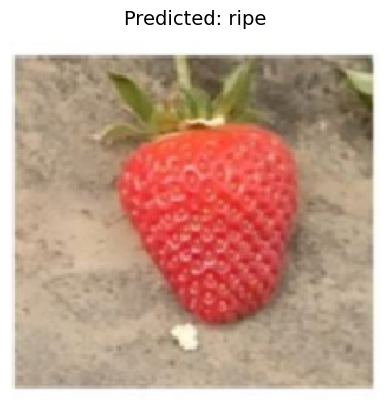

Predicted class index: 0
Predicted class: ripe


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Path to your image
img_path = '/content/Screenshot 2025-06-19 103720.png'  # 🔁 Change this to your actual image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Match your model's input size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Load the trained model
model = load_model('/content/strawberry.h5')  # Or .keras if you saved it that way

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Map index to class name
class_names = ['ripe', 'turning', 'unripe']  # 🔁 Modify if order is different
predicted_class_name = class_names[predicted_class_index]

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_class_name}', fontsize=14)
plt.show()

# Also print it
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class: {predicted_class_name}")


/tmp/ipython-input-31-781872174.py:25: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-31-781872174.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


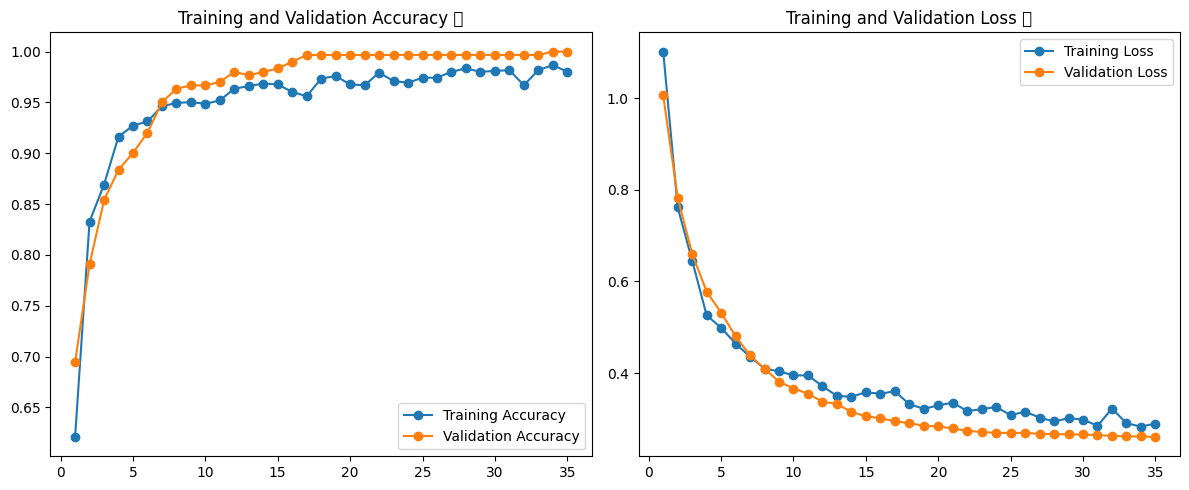

In [31]:
import matplotlib.pyplot as plt
# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy 🎯')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss 📉')

plt.tight_layout()
plt.show()
